In [29]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append("/home/kim2712/Desktop/research/conformal_tree/")
#sys.path.append("/home/kim2712/Desktop/research/rlabc/")

In [31]:
#from rlabc.treeproposal import CARTTree
#CARTTree

In [32]:
from conformal_tree._utils.tree_utils import tree_membership,tester#,tree_plotter
#from conformal_tree._utils.conformal_utils import conf_plotter
#from conformal_tree._data import sin_simul as data_gen
from conformal_tree._nets import network_toy as nt
reload(nt)

<module 'conformal_tree._nets.network_toy' from '/home/kim2712/Desktop/research/conformal_tree/conformal_tree/_nets/network_toy.py'>

In [33]:
import torch
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [34]:
#from scipy.stats import norm
#import pickle
plt.rcParams.update({'font.size': 20})


In [35]:
#path = F"./trained_nets/MNIST.net"
#path = F"./trained_nets/MNIST_half.net"
path = F"./trained_nets/MNIST_smallnet_half.net"
net = nt.MLP(input_dim=28**2, out_dim=10, device = DEVICE, factor=16)#128)
net.load_state_dict(torch.load(path))
net.eval()

MLP(
  (non_linear): LeakyReLU(negative_slope=0.1)
  (l1): Linear(in_features=784, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=16, bias=True)
  (l3): Linear(in_features=16, out_features=16, bias=True)
  (l4): Linear(in_features=16, out_features=10, bias=True)
)

In [36]:
import conformal_tree._data.baseline_data as baseline_data
from torch.utils.data import TensorDataset, DataLoader

(x_train, y_train), (x_calib,y_calib) = baseline_data.get_mnist_np(device = DEVICE, n0=30000)
x_test,y_test = baseline_data.get_mnist_np(device = DEVICE, train=False)

dataset_train = TensorDataset(x_train, y_train)
dataset_calib = TensorDataset(x_calib, y_calib)
dataset_test = TensorDataset(x_test,y_test)

test_loader = DataLoader(dataset_test, batch_size=100, shuffle=True)
train_loader = DataLoader(dataset_train, batch_size=100, shuffle=True)
calib_loader = DataLoader(dataset_calib, batch_size=100, shuffle=True)

In [37]:
soft= torch.nn.Softmax(dim=1)
errors=[]
for i, (x,y) in enumerate(calib_loader, 0):
    with torch.no_grad():
        out = net(x.to(DEVICE)).cpu()
        res= 1-(soft(out) *torch.eye(10)[y]).sum(1)
    errors.append(res.cpu().numpy())
error = np.concatenate(errors)

In [38]:
q_global = np.quantile(error, 0.95)

In [39]:
x_calib = x_calib.cpu().numpy()
y_calib = y_calib.cpu().numpy()

In [40]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import torch

def tester(tree_model, test_loader, q_set, net, preprocess=lambda x: x.cpu()):

    soft= torch.nn.Softmax(dim=1)
    
    I_contains=[]
    C_sizes =[]
    Confuss=[]
    Mores=[]
    Ones =[]
    for i,(x,y) in enumerate(test_loader):
        
        membership = tree_model.apply(preprocess(x))
        mini_batch_q = torch.tensor([q_set[meb] for meb in membership]).float()

        hot_y = torch.eye(10)[y]

        with torch.no_grad():
            out = net(x).cpu()
            res= 1-(soft(out) *hot_y).sum(1)

        C_set_mini_batch = (soft(out)>1-mini_batch_q.view(-1,1))
        C_set_mini_batch = C_set_mini_batch | (soft(out)==(soft(out).max(1)[0].view(-1,1)))
        
        I_contain = (C_set_mini_batch*torch.eye(10)[y]).sum(1)
        
        More = C_set_mini_batch[(C_set_mini_batch.sum(1)>1)]
        One = (C_set_mini_batch.sum(1)==1)
        
        C_size = C_set_mini_batch.sum(1)
        
        Confus = (hot_y.unsqueeze(2) * C_set_mini_batch.unsqueeze(1)).mean(0)

        I_contains.append(I_contain.numpy())
        C_sizes.append(C_size.numpy())
        Confuss.append(Confus.numpy())
        Mores.append(More.sum(1).numpy())
        Ones.append(One.numpy())
    
    I_contains = np.concatenate(I_contains)
    C_sizes = np.concatenate(C_sizes)
    Confuss = np.stack(Confuss).mean(0)
    Mores = np.concatenate(Mores)
    Ones = np.concatenate(Ones).mean()
    
    A_conf = I_contains.mean()
    E_T = C_sizes.mean()
    Co_F=(Confuss**2).sum()
    Ms = Mores.mean()
    
    #print(C_set_mini_batch .sum(1), 
    #      1-mini_batch_q, 
    #      np.round(soft(out).detach().cpu(), decimals=2)[:10])
    
    return A_conf,E_T,Co_F,Ms,Ones, C_sizes

In [41]:
Q = 0.99
q_global = np.quantile(error,Q )

0
1
2
3
4
5
6
7
8
9


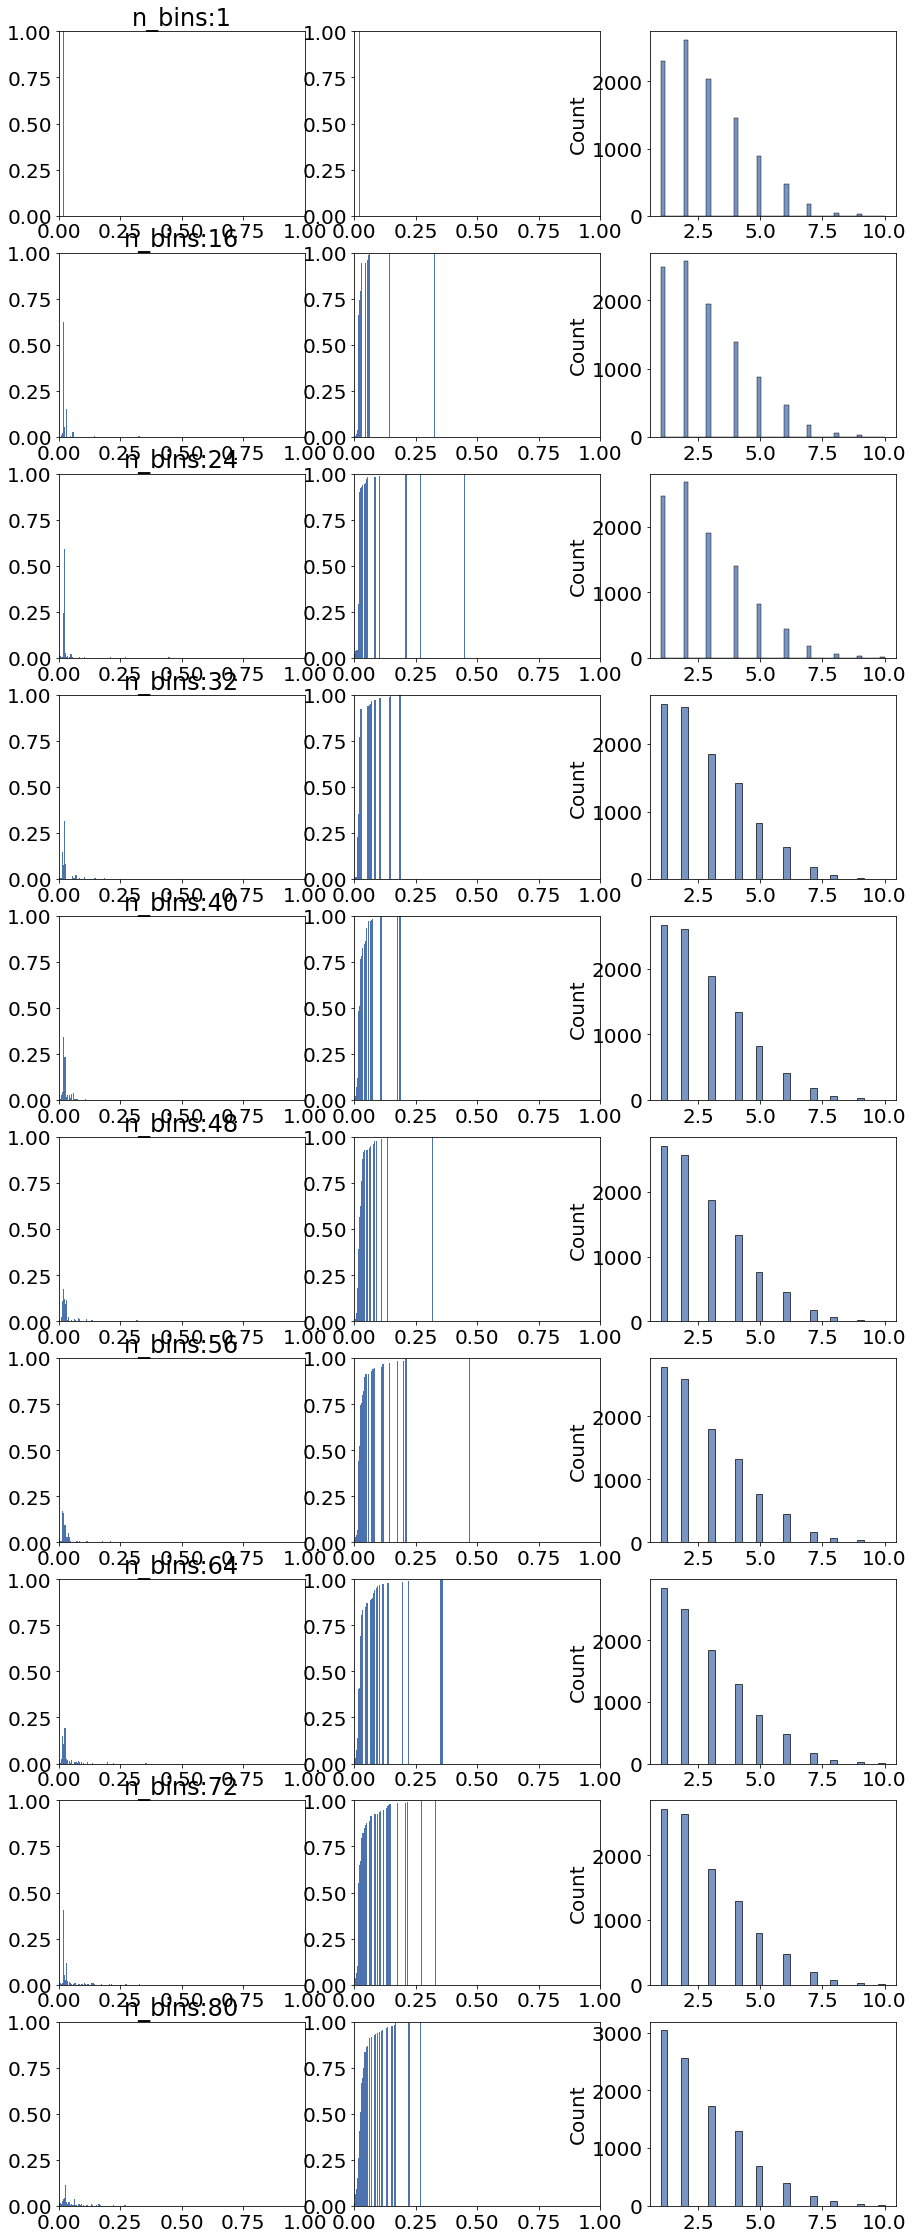

In [42]:
n_iter = 10
import seaborn as sns

fig, axis = plt.subplots(n_iter,3, figsize=(15,n_iter*4))

c_gap  = 0*x_calib[:,0]

plot_stat =[]
calib_stat=[]
test_stat = []
for it in range(n_iter ):
    print(it)
    tree_model, membership = tree_membership(x_calib, c_gap, 
                                             max_depth=20,
                                             max_leaf_nodes=(it+1)*8,
                                             min_samples_leaf=100)
    bin_idx, bin_counts = np.unique(membership, return_counts=True)
    dists = error *0 
    q_set = {}
    
    for idx in bin_idx:
        #idx_counter +=1
        #indices[membership==idx] = idx_counter
        
        error_subset = error[membership==idx]
        q = np.quantile(error_subset, Q)
        dists[membership==idx]=q-error_subset
        #print((membership==idx).sum())
        q_set.update({idx:q})
        #print({idx:q})
    
    A_conf,E_T,Co_F,Ms,Ones, C_sizes = tester(tree_model, calib_loader,q_set,net,
                             preprocess=lambda x: x.cpu())
    calib_stat.append([A_conf,E_T,Co_F,Ms,Ones])
    
    A_conf,E_T,Co_F,Ms,Ones, C_sizes = tester(tree_model, test_loader,q_set,net,
                             preprocess=lambda x: x.cpu())
    test_stat.append([A_conf,E_T,Co_F,Ms,Ones])
    
    #A_conf,E_T,Co_F = tester(tree_model, test_loader,q_set,net,
    #                         preprocess=lambda x: net(x).detach().cpu())
    #test_stat.append([A_conf,E_T,Co_F])
    
    #visualization
    prob = bin_counts/sum(bin_counts)
    neg_q = np.array([1-x for bin_idx, x in q_set.items()])
    
    ax = axis[it,0]
    ax.bar(neg_q,prob , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(F"n_bins:{len(neg_q)}")
    
    order = neg_q.argsort()
    x_axis,y_axis = neg_q[order],np.cumsum(prob[order])
    ax = axis[it,1]
    ax.bar(x_axis,y_axis , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    ax = axis[it,2]
    sns.histplot(C_sizes, ax = ax)#, bw_method=.1)
    
    plot_stat.append([(neg_q,prob),(x_axis,y_axis),C_sizes])
    # update for the next iteration
    c_gap = dists
    #c_gap = q_global-error

No handles with labels found to put in legend.


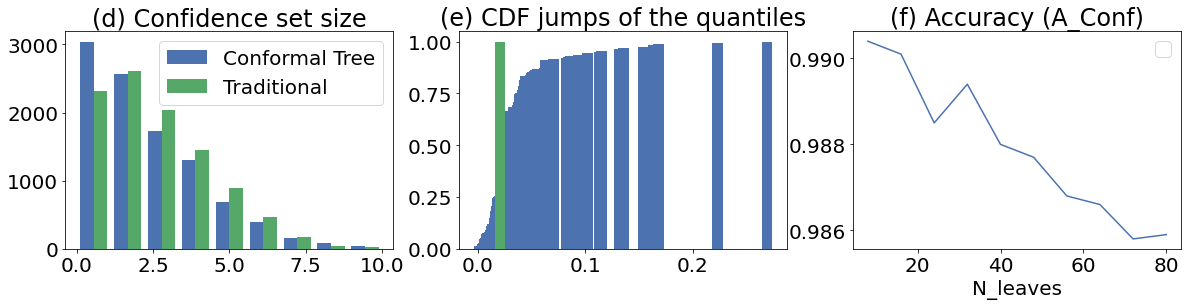

In [43]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')




fig, axis = plt.subplots(1,3, figsize=(20,4))

x = plot_stat[0][2].reshape(-1)
y = plot_stat[-1][2].reshape(-1)

ax=axis[0]
bins = np.linspace(0, 10, 10)
ax.hist([ y,x], bins, label=[ 'Conformal Tree','Traditional'])
ax.legend(loc='upper right')
ax.set_title("(d) Confidence set size")

ax = axis[1]
x = plot_stat[0][1]
y = plot_stat[-1][1]
ax.bar(*y , width=0.01,label='Conformal Tree')
ax.bar(*x , width=0.01,label='Traditional')
ax.set_title("(e) CDF jumps of the quantiles")
plt.legend(loc='upper right')

ax = axis[2]
x = [x[0] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
plt.plot(y,x)
ax.set_title("(f) Accuracy (A_Conf)")
ax.set_xlabel("N_leaves")


plt.show()

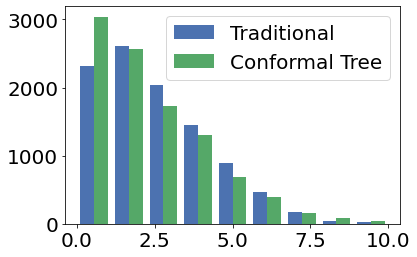

In [44]:
x = plot_stat[0][2].reshape(-1)
y =plot_stat[-1][2].reshape(-1)

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

bins = np.linspace(0, 10, 10)

plt.hist([x, y], bins, label=['Traditional', 'Conformal Tree'])
plt.legend(loc='upper right')
plt.show()

In [45]:
test_stat, calib_stat

([[0.9904, 2.8457, 0.1777276, 3.399817969054739, 0.2309],
  [0.9901, 2.8168, 0.17515606, 3.417243214475785, 0.2484],
  [0.9885, 2.8022, 0.17348625, 3.3914543524416136, 0.2464],
  [0.9894, 2.7968, 0.17227173, 3.4287645309543118, 0.2602],
  [0.988, 2.7564, 0.16976473, 3.3955264593562466, 0.2668],
  [0.9877, 2.744, 0.16857971, 3.394288852278968, 0.2716],
  [0.9868, 2.7322, 0.16685216, 3.4001662740751004, 0.2783],
  [0.9866, 2.7225, 0.16691355, 3.408754020416725, 0.2849],
  [0.9858, 2.7589, 0.16864541, 3.413088215118672, 0.2711],
  [0.9859, 2.6529, 0.16078861, 3.37451515586841, 0.3039]],
 [[0.99, 2.9142, 0.182047, 3.424777266393616, 0.21056666666666668],
  [0.9884667,
   2.8820333333333332,
   0.17935829,
   3.428221228281438,
   0.22493333333333335],
  [0.9879, 2.875, 0.17785119, 3.4302255249287135, 0.22846666666666668],
  [0.98833334, 2.8574, 0.17599918, 3.43753280839895, 0.238],
  [0.9875,
   2.8270666666666666,
   0.17384312,
   3.428103127491805,
   0.24753333333333333],
  [0.98796666

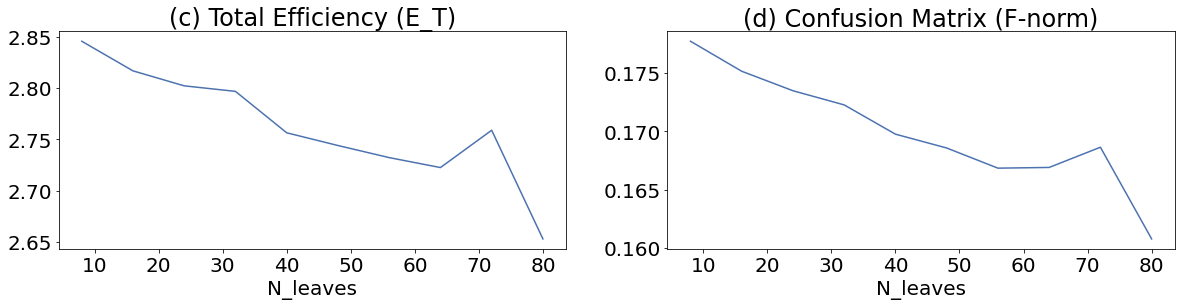

In [46]:

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')




fig, axis = plt.subplots(1,2, figsize=(20,4))

ax = axis[0]
x = [x[1] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
ax.plot(y,x)
ax.set_title("(c) Total Efficiency (E_T)")
ax.set_xlabel("N_leaves")


ax = axis[1]
x = [x[2] for x in test_stat]
y = [(it+1)*8 for it in range(len(x))]
ax.plot(y,x)
ax.set_title("(d) Confusion Matrix (F-norm)")
ax.set_xlabel("N_leaves")


plt.show()

0
1
2
3
4
5
6
7
8
9


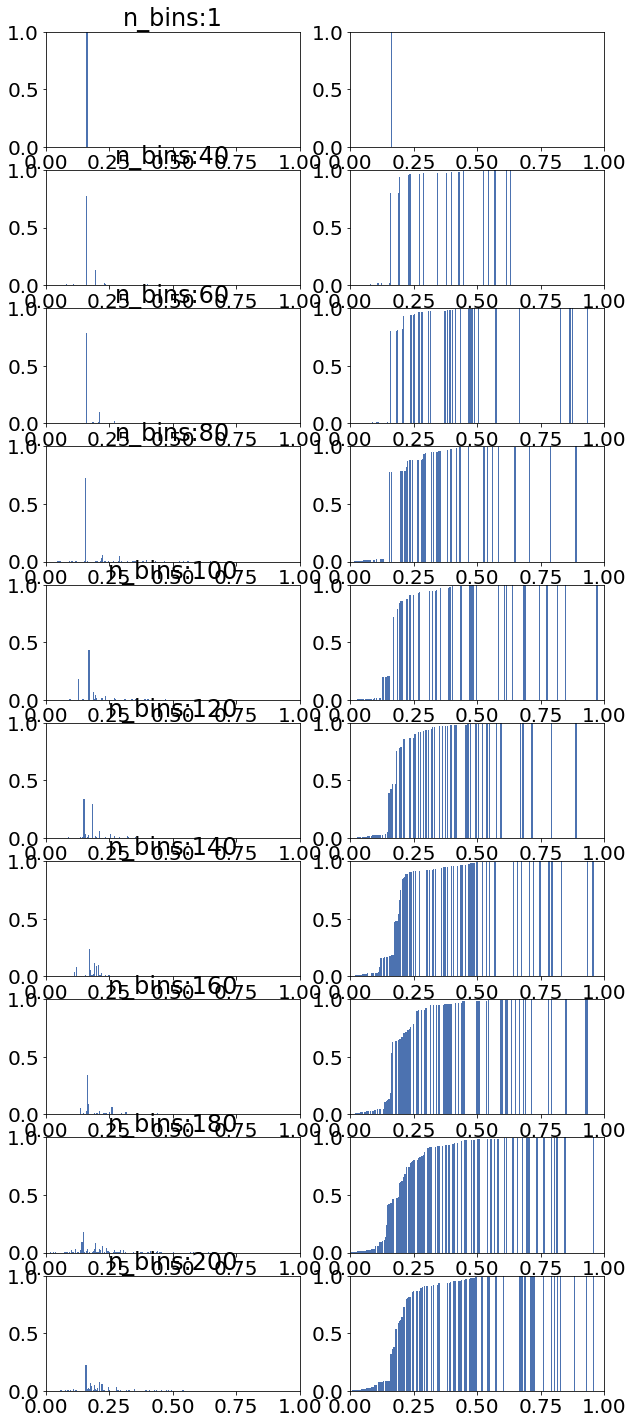

In [47]:
fig, axis = plt.subplots(10,2, figsize=(10,25))

c_gap  = 0*x_calib[:,0]

calib_stat=[]
test_stat = []
for it in range(10):
    print(it)
    tree_model, membership = tree_membership(x_calib, c_gap, max_depth=20,
                                             max_leaf_nodes=(it+1)*20,
                                             min_samples_leaf=1)
    bin_idx, bin_counts = np.unique(membership, return_counts=True)
    dists = error *0 
    q_set = {}
    for idx in bin_idx:

        #idx_counter +=1
        #indices[membership==idx] = idx_counter
        
        x_subset = x_calib[membership==idx]
        error_subset = error[membership==idx]
        q = np.quantile(error_subset, 0.95)
        d_subset = q-error_subset
        dists[membership==idx]=d_subset
        
        q_set.update({idx:q})
    
    #A_conf,E_T,Co_F = tester(tree_model, test_loader,q_set,net,
    #                         preprocess=lambda x: x.cpu())
    calib_stat.append(tester(tree_model, calib_loader,q_set,net,
                             preprocess=lambda x: x.cpu()))
    
    test_stat.append(tester(tree_model, test_loader,q_set,net,
                             preprocess=lambda x: x.cpu()))
    #visualization
    prob = bin_counts/sum(bin_counts)
    neg_q = np.array([1-x for bin_idx, x in q_set.items()])
    
    ax = axis[it,0]
    ax.bar(neg_q,prob , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(F"n_bins:{len(neg_q)}")
    
    order = neg_q.argsort()
    x_axis,y_axis = neg_q[order],np.cumsum(prob[order])
    ax = axis[it,1]
    ax.bar(x_axis,y_axis , width=0.005)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    
    # update for the next iteration
    
    c_gap = dists
    #c_gap = q_global-error
    

In [13]:
test_stat, calib_stat

([(0.9738, 1.0, 0.0953763),
  (0.974, 1.0012, 0.09541402),
  (0.9741, 1.0024, 0.09543352),
  (0.9741, 1.0023, 0.09543465),
  (0.9742, 1.0039, 0.09545474),
  (0.9746, 1.0041, 0.09553607),
  (0.9745, 1.0045, 0.095514044),
  (0.9747, 1.0035, 0.09554431),
  (0.9746, 1.0047, 0.095532626),
  (0.9751, 1.009, 0.09563853)],
 [(0.9439667, 1.0, 0.08966239),
  (0.9445, 1.002, 0.089760296),
  (0.9447, 1.0026666666666666, 0.08980036),
  (0.9449, 1.004, 0.089836285),
  (0.9451333, 1.0052, 0.089886285),
  (0.94533336, 1.0053, 0.08992521),
  (0.94533336, 1.0067, 0.08992664),
  (0.94553334, 1.0063666666666666, 0.08996312),
  (0.9453, 1.0074333333333334, 0.089921206),
  (0.94706666, 1.0120333333333333, 0.090248846)])

([(0.9738, 1.0, 0.09537631),
  (0.9738, 1.0002, 0.09537726),
  (0.9739, 1.0015, 0.09539789),
  (0.974, 1.0022, 0.09541653),
  (0.9741, 1.0021, 0.095436126),
  (0.9742, 1.0032, 0.09545554),
  (0.9742, 1.0036, 0.095455915),
  (0.9748, 1.0059, 0.09557276),
  (0.9747, 1.008, 0.09555551),
  (0.9747, 1.0071, 0.09555618)],
 [(0.9439667, 1.0, 0.08966237),
  (0.9442, 1.0012666666666667, 0.089708075),
  (0.9443, 1.0019666666666667, 0.08972729),
  (0.9446, 1.0025333333333333, 0.08978318),
  (0.9447333, 1.0030666666666668, 0.08980915),
  (0.945, 1.0041, 0.08986076),
  (0.94533336, 1.0056666666666667, 0.08992587),
  (0.9457, 1.0075666666666667, 0.089997716),
  (0.9457333, 1.0084, 0.09000812),
  (0.94586664, 1.0101333333333333, 0.09003662)])

[[0.9601, 0.9751, 0.09275233],
 [0.9597, 0.975, 0.09269646],
 [0.9608, 0.9786, 0.09291676],
 [0.9602, 0.9787, 0.09278675],
 [0.9612, 0.9793, 0.09298554],
 [0.9613, 0.9814, 0.092999905],
 [0.9606, 0.9812, 0.09287888],
 [0.9613, 0.9828, 0.093004376],
 [0.9613, 0.983, 0.09302397],
 [0.9612, 0.9829, 0.09298614]]